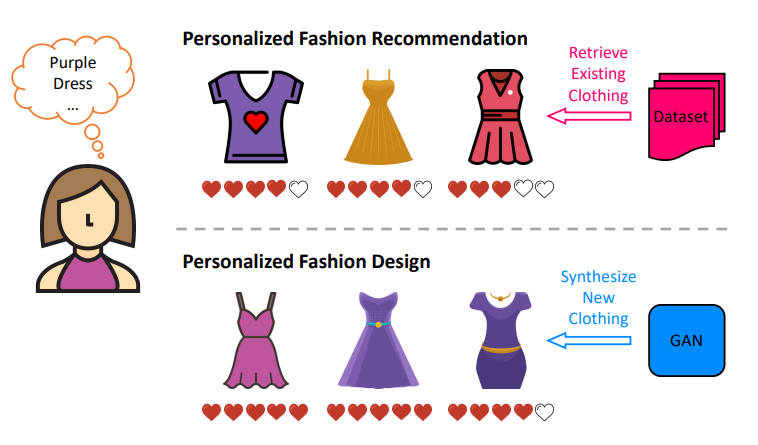

Building effective recommender systems for domains like fashion is challenging due to the high level of subjectivity and the semantic complexity of the features involved (i.e., fashion styles). Recent work has shown that approaches to ‘visual’ recommendation (e.g. clothing, art, etc.) can be made more accurate by incorporating visual signals directly into the recommendation objective, using ‘off-the-shelf’ feature representations derived from deep networks. Here, we seek to extend this contribution by showing that recommendation performance can be significantly improved by learning ‘fashion aware’ image representations directly, i.e., by training the image representation (from the pixel level) and the recommender system jointly; this contribution is related to recent work using Siamese CNNs, though we are able to show improvements over state-of-the-art recommendation techniques such as BPR and variants that make use of pretrained visual features.

### Key feature
Siamese network and Implicit feedback with BPR loss on 2 models - 1) Convolutional Autoencoder (CAE), and 2) Pre-trained InceptionV3.

In [3]:
# global libraries
import os
import sys

import random
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

from IPython.display import display
from keras import backend as K
from keras.models import model_from_yaml
from keras.utils.np_utils import to_categorical   
from keras.regularizers import l2
from keras.optimizers import Adam
# Libraries

from io import StringIO, BytesIO
import requests

from keras import backend as K

import random
import numpy as np
from datetime import datetime
from pytz import timezone

from PIL import Image

# CNN Libraries
import numpy as np

from keras import backend as K
from keras.models import Sequential
from keras.layers import ZeroPadding2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Flatten, Dense
from keras.regularizers import l2

# Siamese Libraries
from keras.models import Model
from keras.layers import Input, Lambda, Concatenate, Dot, Embedding, Flatten
import tensorflow as tf

# CAE Libraries
import math
from keras.layers import Dense, Conv2D, Flatten, Conv2DTranspose, BatchNormalization, MaxPooling2D, Reshape
import keras
from keras.preprocessing.image import img_to_array, array_to_img

### CAE-based DVBPR model

On the left side, the convolutional autoencoder training process is presented. After it’s trained, we take only the encoder, freeze its layers, add a trainable layer and use it in the siamese network as presented on the right side of the figure.

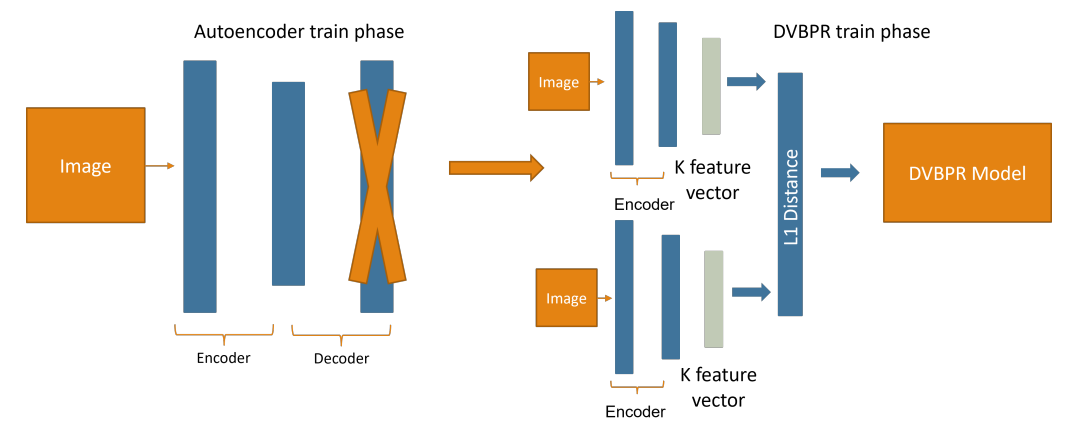

### Imagenet-based DVBPR model

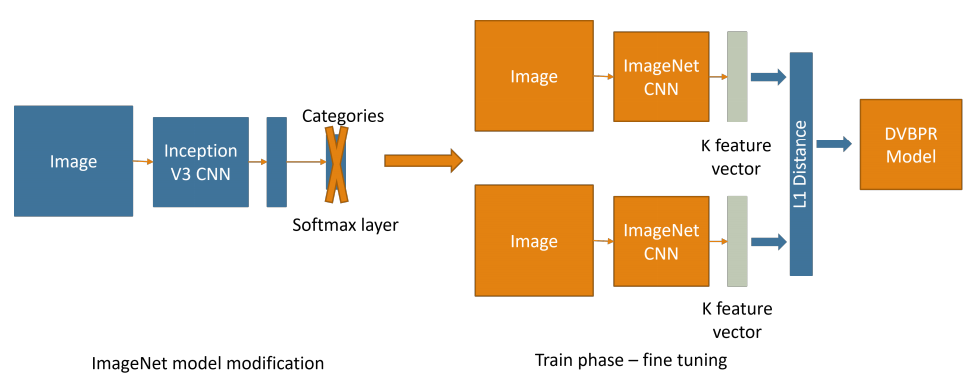

### Datasets

Three datasets - AmazonFashion and AmazonMen which consist of reviews of clothing items crawled from Amazon.com and the third one was crawled from Tradesy.com, which is a c2c online platform for buying and selling used fashion items.

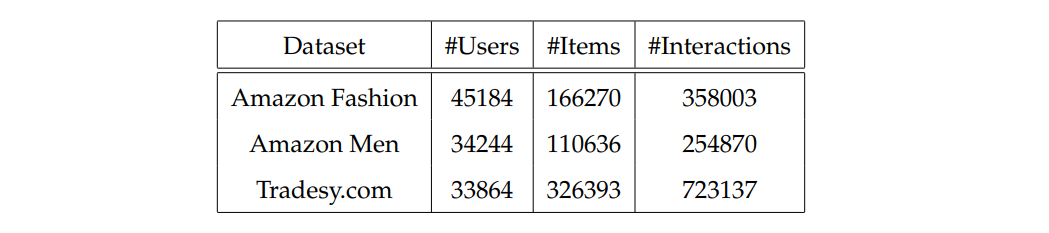

At our training phase, we first sampled for each user an item that he was interacted with, and another item that he was not. We extracted the images for each item and inserted them into our Siamese network together with the user ID. For efficiency, we split the data into batches, while the batch size selected from {64,128,256}. We found out that the performance of all batch sizes were similar, but the running time was different, so we chose a batch size of 128 samples which gave the fastest results.

In [5]:
# 1 - Amazon Fashion, 2 - Amazon Men, 3 - Tradesy

dataset = 2

if dataset==1:
  #size - 3.26GB
  if not os.path.exists("AmazonFashion6ImgPartitioned.npy"):
    !wget http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonFashion6ImgPartitioned.npy
  dataset = np.load("AmazonFashion6ImgPartitioned.npy",
                  encoding="bytes", allow_pickle=True)
elif dataset==2:
  #size - 2.12GB
  if not os.path.exists("AmazonMenWithImgPartitioned.npy"):
    !wget http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonMenWithImgPartitioned.npy
  dataset = np.load("AmazonMenWithImgPartitioned.npy",
                    encoding="bytes", allow_pickle=True)
  [user_train, user_validation, user_test, items, user_num, item_num] = dataset
elif dataset==3:
  #size - 3.40GB
  if not os.path.exists("TradesyImgPartitioned.npy"):
    !wget http://cseweb.ucsd.edu/~wckang/DVBPR/TradesyImgPartitioned.npy
  dataset = np.load("TradesyImgPartitioned.npy",
                    encoding="bytes", allow_pickle=True)
  [user_train, user_validation, user_test, items, user_num, item_num] = dataset
else:
  print("please select the right dataset!")

### Hyperparameters

In [6]:
# Network params
# image size
image_width = 224
image_height = 224

# latent dimensionality K
latent_dimensionality = 50

# weight decay - conv layer
lambda_cnn = 0.001
# weight decay - fc layer
lambda_fc = 0.001
# regularizer for theta_u
lambda_u = 1.0

# Training params
# epoch params
learning_rate = 1e-4
training_epoch = 3 # 30
batch_count = 2**8
# batch_size = 2**7
validation_sample_count = 100

### Earlier method

Previous models for visually-aware recommendation made use of pre-trained visual features, adding additional item factors by embedding the visual features into a lowdimensional space.

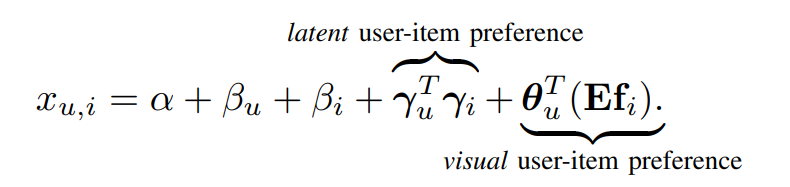

The main issue we seek to address with the method above is its reliance on pre-trained features that were optimized for a different task (namely, classification on ImageNet). Thus we wish to evaluate the extent to which task-specific features can be used to improve performance within an end-to-end framework. This builds upon recent work on comparative image models, though differs in terms of the formulation and training objective used.

In [ ]:
!pip install tensorflow==2.5

In [7]:
# global libraries
import os
import sys
import random
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import display
# Libraries
from io import StringIO, BytesIO
import requests
from pytz import timezone
from PIL import Image

In [8]:
# CNN Libraries
import tensorflow as tf
import tensorflow.keras as keras

In [25]:
# Tensorflow libraries
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, MaxPooling2D, BatchNormalization, Conv2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Siamese Libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Concatenate, Dot, Embedding

In [26]:
# Network params
# image size
image_width = 224
image_height = 224

# latent dimensionality K
latent_dimensionality = 50

# weight decay - conv layer
lambda_cnn = 0.001
# weight decay - fc layer
lambda_fc = 0.001
# regularizer for theta_u
lambda_u = 1.0

In [27]:
# Training params
# epoch params
learning_rate = 1e-4
validation_sample_count = 100

# CNN Model

In [28]:
def CNN(width, height, depth, latent_dim, w_init="RandomNormal", cnn_w_regularizer=None, fc_w_regularizer=None, b_init="RandomNormal"):
    """
    Build the CNN.

        :param width (int): Image width in pixels.
        :param height (int): The image height in pixels.
        :param depth (int): The number of channels for the image.
        :param latent_dim (int): Dimesion of the latent space - embedding of the image.
        :param w_init="he_normal" (str): The kernel initializer.
        :param cnn_w_regularizer=None (str): Regularization method.
        :param fc_w_regularizer=None (str): Regularization method.
    """

    # Initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = Sequential(name='cnn')
    input_shape = (height, width, depth)
    chan_dim = -1

    # if we are using "channels first", update the input shape
    # and channels dimension
    if K.image_data_format() == "channels_first":
        input_shape = (depth, height, width)
        chan_dim = 1

    # conv1
    #
    # Our first CONV layer will learn a total of 64 filters, each
    # of which are 11x11 -- we'll then apply 4x4 strides to reduce
    # the spatial dimensions of the volume
    # Moreover, a max-pooling layer is added
    model.add(Conv2D(64, (11, 11),
                      strides=(4, 4),
                      padding="same",
                      kernel_initializer=w_init,
                      kernel_regularizer=cnn_w_regularizer,
                      bias_initializer=b_init,
                      input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),
                            padding="same"))

    # conv2
    #
    # Here we stack one more CONV layer on top,
    # each layer will learn a total of 256 (5x5) filters
    # A max-pooling layer is added
    model.add(Conv2D(256, (5, 5),
                      padding="same",
                      strides=(1, 1),
                      kernel_initializer=w_init,
                      kernel_regularizer=cnn_w_regularizer,
                      bias_initializer=b_init))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),
                            padding="same"))

    # conv3
    #
    # Stack one more CONV layer, keeping 256 total learned filters
    # but decreasing the the size of each filter to 3x3
    model.add(Conv2D(256, (3, 3),
                      padding="same",
                      strides=(1, 1),
                      kernel_initializer=w_init,
                      kernel_regularizer=cnn_w_regularizer,
                      bias_initializer=b_init))
    model.add(Activation("relu"))

    # Two more CONV layers, same filter size and number
    #
    # conv4
    model.add(Conv2D(256, (3, 3),
                      padding="same",
                      strides=(1, 1),
                      kernel_initializer=w_init,
                      kernel_regularizer=cnn_w_regularizer,
                      bias_initializer=b_init))
    model.add(Activation("relu"))

    # conv5
    model.add(Conv2D(256, (3, 3),
    
                      strides=(1, 1),
                      kernel_initializer=w_init,
                      kernel_regularizer=cnn_w_regularizer,
                      bias_initializer=b_init))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),
                            padding="same"))

    # Two fully-connected layers on top of each other
    #
    # full1
    model.add(Flatten())
    model.add(Dense(4096,
                    kernel_initializer=w_init,
                    kernel_regularizer=fc_w_regularizer,
                    bias_initializer=b_init))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))

    # full2
    model.add(Dense(4096,
                    kernel_initializer=w_init,
                    kernel_regularizer=fc_w_regularizer,
                    bias_initializer=b_init))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))

    # full3
    model.add(Dense(latent_dim,
                    kernel_initializer=w_init,
                    kernel_regularizer=fc_w_regularizer,
                    bias_initializer=b_init))


    # Return the constructed network architecture
    return model

# Subsets

In [13]:
# get user information
user_num_original = user_num
user_train_original = user_train

In [14]:
# for each batch, force the number of users to be the same
batch_size = 128
batch_count = int(np.ceil(user_num_original / batch_size))

# one complete model will be linked to each user_subset
user_subsets = dict(zip(range(batch_count), np.array_split(range(user_num_original), batch_count)))

# Utils

In [15]:
# translate image from byte code to an array and normalize its values from 0-255 to -1 - 1
def image_translate(image_bytes,
                    image_width=224,
                    image_height=224):
    img = (np.uint8(np.asarray(Image.open(BytesIO(image_bytes)).convert("RGB").resize((image_height, image_width)))) - 127.5)  / 127.5
    return img

In [16]:
# get train batches which was sampled uniformly for each user
def uniform_train_sample_batch(user_train_ratings, item_images, image_width=224, 
                               image_height=224, sample=True, batch_size=None, user_idx=None):


    if batch_size is not None:
        users = range(batch_size)
    else:
        users = user_idx

    triplet_train_batch = {}
    
    # iterate over each user in subset
    for b in users:

        # training set
        if sample:
            u = random.randrange(len(user_train_ratings))
        else:
            u = b

        i = user_train_ratings[u][random.randrange(len(user_train_ratings[u]))][b'productid']
        j = random.randrange(len(item_images))
        
        # while the sampled items observed by the user - sample other item until found non-observed item
        while j in [item[b'productid'] for item in user_train_ratings[u]]:
            j = random.randrange(len(item_images))

        image_i = image_translate(item_images[i][b'imgs'], 
                                  image_width, 
                                  image_height)
        image_j = image_translate(item_images[j][b'imgs'],
                                  image_width, 
                                  image_height)
        triplet_train_batch[u] = [image_i,
                                  image_j]
        
    return triplet_train_batch

In [17]:
# get validation batches which was sampled uniformly for each user
def uniform_validation_sample_batch(user_train_ratings,
                                    user_validation_ratings,
                                    item_images,
                                    image_width=224,
                                    image_height=224,
                                    validation_sample_count=1000,
                                    sample=True,
                                    batch_size=None,
                                    user_idx=None):
    """
    validation_sample_count (int): Number of not-observed items to sample to get the validation set for each user.
    """

    if batch_size is not None:
        users = range(batch_size)
    else:
        users = user_idx

    triplet_validation_batch = {}
    
    # iterate over each user in subset
    for b in users:

        if sample:
            u = random.randrange(len(user_train_ratings))
        else:
            u = b

        # validation set
        i = user_validation_ratings[u][0][b'productid']
        # get its image
        image_i = image_translate(item_images[i][b'imgs'],
                                  image_width, 
                                  image_height)

        # create a set of all user observed items
        reviewed_items = set()
        for item in user_train_ratings[u]:
            reviewed_items.add(item[b'productid'])
        reviewed_items.add(user_validation_ratings[u][0][b'productid'])

        # search for a non-observed item
        triplet_validation_batch[u] = []
        got = False
        for j in random.sample(range(len(item_images)), validation_sample_count):
            if j not in reviewed_items:
                image_j = image_translate(item_images[j][b'imgs'],
                                          image_width, 
                                          image_height)
                triplet_validation_batch[u] = [image_i, image_j]
                got = True
            
            if got:
              break

    return triplet_validation_batch

In [18]:
# Define the loss function as ln(sigmoid) according to the BPR method
# BPR wants to maximize the loss function while Keras engine minimizes it so we added a subtraction 
def bpr_loss(label_matrix, prediction_matrix):
    return 1 - tf.reduce_sum(tf.math.log(tf.sigmoid(prediction_matrix)))

In [19]:
# Count the ratio of prediction value > 0
# i.e., predicting positive item score > negative item score for a user
def auc(label_tensor, prediction_tensor):
    return K.mean(K.switch(prediction_tensor > K.zeros_like(prediction_tensor),
                           K.ones_like(prediction_tensor),    # 1
                           K.zeros_like(prediction_tensor)))  # 0

# Siamese Network

In [29]:
def ConvSiameseNet(users_dim, width, height, depth,latent_dim, w_init="RandomNormal", cnn_w_regularizer=None, fc_w_regularizer=None, u_w_regularizer=None, b_init="RandomNormal"):

        # user ID input  
        user_input = Input((1,), name='User')

        image_shape = (width, height, depth)
        
        # observed image
        left_input = Input(image_shape,
                           name="observed_image")
        # non-observed image
        right_input = Input(image_shape,
                            name="non_observed_image")

        # Build convnet to use in each siamese 'leg'
        conv_net = CNN(width, height, depth, latent_dim, w_init, fc_w_regularizer, b_init)

        # preference layer
        preference_relationship = Dot(axes=1,
                                      name="score_rank")

        # Apply the pipeline to the inputs
        # call the convnet Sequential model on each of the input tensors
        # so params will be shared
        encoded_l = conv_net(left_input)
        encoded_r = conv_net(right_input)

        # merge the two encoded inputs through the L1 distance
        L1_dist = tf.keras.layers.Subtract()([encoded_l, encoded_r])
        
        # retrieve the single user preference
        user_vec = Flatten(name='FlattenUsers')(Embedding(user_num+1, latent_dimensionality, name = 'User-Embedding', embeddings_initializer= tf.keras.initializers.RandomUniform(0,0.01),
                                                          input_length=1, embeddings_regularizer=u_w_regularizer)(user_input))
        
        # get the preference score
        prediction = preference_relationship([user_vec, L1_dist])
        
        # Create the model
        model = Model(inputs=[user_input, left_input, right_input],
                      outputs=prediction)
        
        model.summary()
        
        
        return model

# Build Model

In [30]:
# build the model with the regularization hyper-parameters and initializers
conv_siamese_net = ConvSiameseNet(users_dim=len(user_subsets[0]),
                                        width=image_width,
                                        height=image_height,
                                        depth=3,
                                        latent_dim=latent_dimensionality,
                                        cnn_w_regularizer=l2(lambda_cnn),
                                        fc_w_regularizer=l2(lambda_fc),
                                        u_w_regularizer=l2(lambda_u),
                                        w_init = tf.keras.initializers.GlorotNormal(),
                                  b_init = tf.keras.initializers.GlorotNormal())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
observed_image (InputLayer)     [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
non_observed_image (InputLayer) [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 50)        1712250     User[0][0]                       
______________________________________________________________________________________________

In [31]:
# compile the model
optimizer = Adam(learning_rate)
conv_siamese_net.compile(loss=bpr_loss,
                         optimizer=optimizer,
                         metrics=[auc])

# Train

In [32]:
# get train subset using the uniform sampling
def get_train(user_subset, user_train):
  train = uniform_train_sample_batch(
      sample=False,
      user_idx=user_subset,
      user_train_ratings=user_train,
      item_images=items,
      image_width=image_width,
      image_height=image_height)
  return train

In [33]:
# get validation subset using the uniform sampling
def get_validation(user_subset, user_train):
  validation = uniform_validation_sample_batch(
      sample=False,
      user_idx=user_subset,
      user_train_ratings=user_train,
      user_validation_ratings=user_validation,
      item_images=items,
      image_width=image_width,
      image_height=image_height,
      validation_sample_count=validation_sample_count)
  return validation

In [34]:
# create triplets lists with the user ID and the two images - train
def get_train_triplet_lists(train):
    user_placeholder = []
    observed_image = []
    not_observed_image = []
    
    for u, triplet in train.items():
        user_placeholder.append(u)
        observed_image.append(triplet[0])
        not_observed_image.append(triplet[1])
        
    # label set does not exist in BPR, so we give Keras with a dummy label set
    labels = np.ones((len(train), 1), dtype=int)
    
    return user_placeholder, observed_image, not_observed_image, labels

In [35]:
# create triplets lists with the user ID and the two images - validation
def get_val_triplet_lists(validation):
    user_placeholder = []
    observed_image = []
    not_observed_image = []

    for u, triplet in validation.items():      
      user_placeholder.append(u)
      observed_image.append(triplet[0])
      not_observed_image.append(triplet[1])
    
    # label set does not exist in BPR, so we give Keras with a dummy label set
    labels = np.ones((len(validation), 1), dtype=int)

    return user_placeholder, observed_image, not_observed_image, labels

In [36]:
# generate train batches throughout the training phase - yields triplet batches
def generator():
  batches = range(batch_count)
  num_batches_in_curr_epoch = 0
  user_subset_idx = 0
  while True:
    user_subset = user_subsets[user_subset_idx] # get batch users
    user_train = {k: v for k, v in user_train_original.items() if k in user_subset}
    train = get_train(user_subset, user_train)
    user_placeholder, observed_image, not_observed_image, labels = get_train_triplet_lists(train)
    
    yield [np.asarray(user_placeholder), np.asarray(observed_image), np.asarray(not_observed_image)], np.asarray(labels)
    
    num_batches_in_curr_epoch+=1
    user_subset_idx+=1
    
    if num_batches_in_curr_epoch >= batch_count:
      # reset the lists
      num_batches_in_curr_epoch = 0
      user_subset_idx = 0

In [37]:
# generate validation batches throughout the evaluation phase - yields triplet batches
def val_generator():
  batches = range(batch_count)
  num_batches_in_curr_epoch = 0
  user_subset_idx = 0
  while True:
    user_subset = user_subsets[user_subset_idx] # get batch users
    validation = get_validation(user_subset, user_validation)
    user_placeholder, observed_image, not_observed_image, labels = get_val_triplet_lists(validation)
    
    yield [np.asarray(user_placeholder), np.asarray(observed_image), np.asarray(not_observed_image)], np.asarray(labels)

    num_batches_in_curr_epoch+=1
    user_subset_idx+=1
    
    if num_batches_in_curr_epoch >= batch_count:
      # reset the lists
      num_batches_in_curr_epoch = 0
      user_subset_idx = 0

In [38]:
# data generators for training and avaluation
train_generator = generator()
validation_generator = val_generator()

In [39]:
# conv_siamese_net.fit(x=train_generator, steps_per_epoch = num_batches, validation_data=validation_generator, validation_steps=batch_count, epochs = 20)

In [40]:
# Training 
val_scores = []
history = []
model_path = "conv_siamese_net_trained_model_implementation_20_epochs"

for i in range(2):
  history.append(conv_siamese_net.fit(x=train_generator, steps_per_epoch = batch_count, epochs = 10)) # train
  val_scores.append(conv_siamese_net.evaluate(validation_generator, steps = batch_count)) # validation
  print(val_scores)
  conv_siamese_net.save(model_path, save_traces=True, include_optimizer=True) # save model

Epoch 1/10


TypeError: ignored

In [ ]:
# remove garbage
import gc
gc.collect()

# Load Model

In [ ]:
# load pretrained model
model_path = "conv_siamese_net_trained_model_ImageNet_20_epochs"
conv_siamese_net = tf.keras.models.load_model(model_path, custom_objects={'auc': auc, 'bpr_loss': bpr_loss})

In [ ]:
# compile the model
optimizer = Adam(learning_rate)
conv_siamese_net.compile(loss=bpr_loss,
                         optimizer=optimizer,
                         metrics=[auc])

# Test

In [ ]:
# test set generator - yields batches through evaluation
def test_generator():
  batches = range(batch_count)
  num_batches_in_curr_epoch = 0
  user_subset_idx = 0
  while True:
    user_subset = user_subsets[user_subset_idx] # get batch users
    test = get_validation(user_subset, user_test)  
    user_placeholder, observed_image, not_observed_image, labels = get_val_triplet_lists(test)
    
    yield [np.asarray(user_placeholder), np.asarray(observed_image), np.asarray(not_observed_image)], np.asarray(labels)

    num_batches_in_curr_epoch+=1
    user_subset_idx+=1
    
    if num_batches_in_curr_epoch >= batch_count:
      # reset the lists
      num_batches_in_curr_epoch = 0
      user_subset_idx = 0

In [ ]:
# evaluate on test set
test_gen = test_generator()
conv_siamese_net.evaluate(test_gen, steps = batch_count)